SPAM SMS CLASSIFICATION USING NLP

Import Libraries


In [8]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

 Load the Dataset

In [9]:
df = pd.read_csv('/content/Spam_SMS.csv')  # Replace with your file path

# Display first few rows of the dataset
print(df.head())
print(df.info())
# Check class distribution
print(df['Class'].value_counts())


  Class                                            Message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5574 entries, 0 to 5573
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Class    5574 non-null   object
 1   Message  5574 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB
None
Class
ham     4827
spam     747
Name: count, dtype: int64


In [ ]:
df.isnull().sum()

,0
Class,0
Message,0


Exploratory Data Analysis (EDA)

<ipython-input-10-2aa5c9a41be1>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Class', palette='husl')


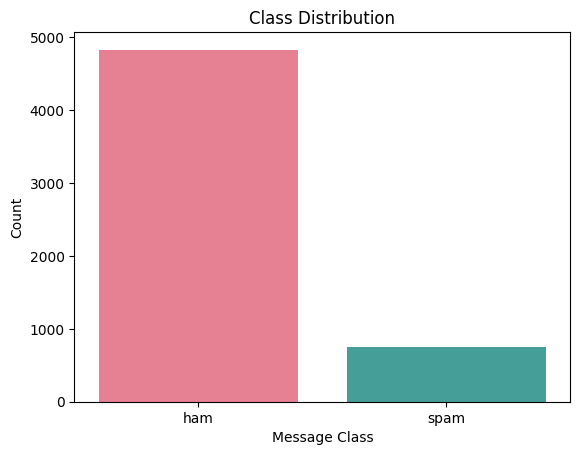

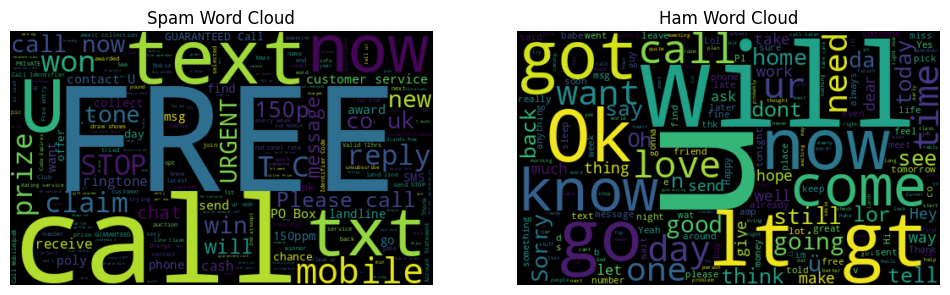

In [10]:
#Visualize the class distribution and generate word clouds
# Check class distribution
sns.countplot(data=df, x='Class', palette='husl')
plt.title('Class Distribution')
plt.xlabel('Message Class')
plt.ylabel('Count')
plt.show()

# Word clouds for spam and ham
spam_words = ' '.join(df[df['Class'] == 'spam']['Message'])
ham_words = ' '.join(df[df['Class'] == 'ham']['Message'])

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Spam Word Cloud")
spam_cloud = WordCloud(width=500, height=300).generate(spam_words)
plt.imshow(spam_cloud, interpolation='bilinear')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Ham Word Cloud")
ham_cloud = WordCloud(width=500, height=300).generate(ham_words)
plt.imshow(ham_cloud, interpolation='bilinear')
plt.axis('off')

plt.show()

Data Cleaning

In [11]:
#Clean the SMS messages using text preprocessing techniques
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # Remove special characters and numbers
    text = re.sub(r'\W', ' ', text)
    # Convert to lowercase
    text = text.lower()
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    # Remove stopwords
    words = [word for word in text.split() if word not in stopwords.words('english')]
    # Lemmatize words
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

df['Cleaned_Message'] = df['Message'].apply(clean_text)
print(df[['Message', 'Cleaned_Message']].head())

                                             Message  \
0  Go until jurong point, crazy.. Available only ...   
1                      Ok lar... Joking wif u oni...   
2  Free entry in 2 a wkly comp to win FA Cup fina...   
3  U dun say so early hor... U c already then say...   
4  Nah I don't think he goes to usf, he lives aro...   

                                     Cleaned_Message  
0  go jurong point crazy available bugis n great ...  
1                            ok lar joking wif u oni  
2  free entry 2 wkly comp win fa cup final tkts 2...  
3                u dun say early hor u c already say  
4                nah think go usf life around though  


Train-Test Split

In [12]:
#Split the dataset into training and testing sets
X = df['Cleaned_Message']
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Text Vectorization

In [13]:
#Convert text data into numerical form using TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train).toarray()
X_test_tfidf = tfidf.transform(X_test).toarray()

Model Training


In [15]:
# Initialize Train models to classify the SMS messages
models = {
    'Naive Bayes': MultinomialNB()
}

# Train and evaluate
results = {}
for model_name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    accuracy = accuracy_score(y_test, y_pred)
    results[model_name] = accuracy
    print(f"\n{model_name} Classification Report:\n")
    print(classification_report(y_test, y_pred))

print("\nModel Accuracies:")
for model, acc in results.items():
    print(f"{model}: {acc:.2%}")


Naive Bayes Classification Report:

              precision    recall  f1-score   support

         ham       0.97      1.00      0.98      1203
        spam       0.99      0.80      0.88       191

    accuracy                           0.97      1394
   macro avg       0.98      0.90      0.93      1394
weighted avg       0.97      0.97      0.97      1394


Model Accuracies:
Naive Bayes: 97.13%


Confusion Matrix

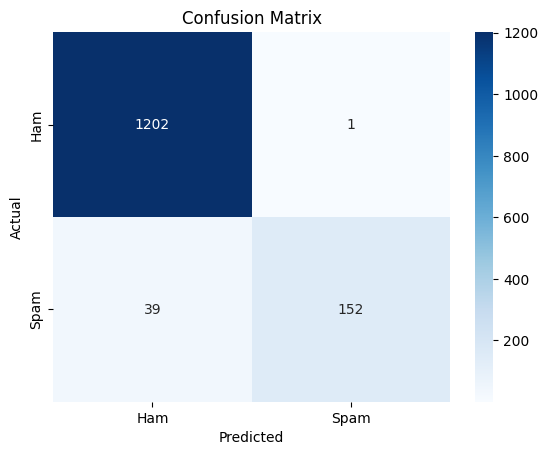

In [16]:
#Visualize the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

Validation with ROC-AUC

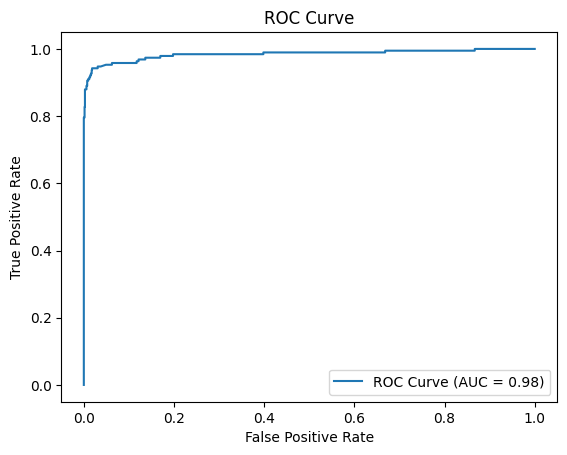

In [17]:
#Validation with ROC-AUC
from sklearn.metrics import roc_auc_score, roc_curve

y_pred_prob = models['Naive Bayes'].predict_proba(X_test_tfidf)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_prob, pos_label='spam')
plt.plot(fpr, tpr, label="ROC Curve (AUC = {:.2f})".format(roc_auc_score(y_test, y_pred_prob)))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()